In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [43]:
original_test_df = pd.read_csv('./Data/test.csv')
original_train_df = pd.read_csv('./Data/train.csv')

In [44]:
def titanic_data_shaping(df):
    # Sex
    df.Sex = df.Sex.map({'female':0,'male':1})

    # Title
    # Regexp tips :
    # () : matches the group within
    # + : matches the expression to its left one or more times
    # \. search for '.' otherwise . alone is a special character
    # '([A-Za-z]+)\.' search for matches to groups of letters ending with a .

    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
    least_occuring_titles = ['Dr','Rev','Major','Col','Capt','Jonkheer','Don','Sir']
    df['Feature_Title']=df['Title']
    df['Feature_Title']=df['Feature_Title'].replace(['Ms','Mme','Countess'],'Mrs')
    df['Feature_Title']=df['Feature_Title'].replace(['Lady','Mlle'],'Miss')
    df['Feature_Title']=df['Feature_Title'].replace(least_occuring_titles,'Rare')
    df.Feature_Title.value_counts()
    df.Feature_Title = df.Feature_Title.map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Rare':4},na_action='ignore')

    df["Ticket Number"] = [int(df.iloc[i]["Ticket"].split()[-1]) if df.iloc[i]["Ticket"].split()[-1] != 'LINE' else 0 for i in range(len(df)) ]
    df["Ticket Number"] = (df["Ticket Number"] - df["Ticket Number"].mean()) / (df["Ticket Number"].max() - df["Ticket Number"].min())

    # Training Data shuffle
    df = df.reindex(np.random.permutation(df.index))

    # Age
    df['Feature_Age'] = df['Age'].fillna(df['Age'].median())
    
    return df

train_df = titanic_data_shaping(original_train_df)
test_df = titanic_data_shaping(original_test_df)


In [45]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Feature_Title,Ticket Number,Feature_Age
290,1182,1,"Rheims, Mr. George Alexander Lucien",1,NaN,0,0,PC 17607,39.6000,NaN,S,Mr,0.0,-0.076031,27.00
267,1159,3,"Warren, Mr. Charles William",1,NaN,0,0,C.A. 49867,7.5500,NaN,S,Mr,0.0,-0.065629,27.00
144,1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",1,42.00,0,0,17475,26.5500,NaN,S,Mr,0.0,-0.076074,42.00
376,1268,3,"Kink, Miss. Maria",0,22.00,2,0,315152,8.6625,NaN,S,Miss,1.0,0.019910,22.00
130,1022,3,"Spinner, Mr. Henry John",1,32.00,0,0,STON/OQ. 369943,8.0500,NaN,S,Mr,0.0,0.037577,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,1214,2,"Nesson, Mr. Israel",1,26.00,0,0,244368,13.0000,F2,S,Mr,0.0,-0.002914,26.00
377,1269,2,"Cotterill, Mr. Henry Harry""""",1,21.00,0,0,29107,11.5000,NaN,S,Mr,0.0,-0.072323,21.00
366,1258,3,"Caram, Mr. Joseph",1,NaN,1,0,2689,14.4583,NaN,C,Mr,0.0,-0.080842,27.00
86,978,3,"Barry, Miss. Julia",0,27.00,0,0,330844,7.8792,NaN,Q,Miss,1.0,0.024970,27.00


In [46]:
def build_model(model_learning_rate,feature_size,classification_threshold):
    model = tf.keras.models.Sequential()
  
    model.add(tf.keras.layers.Dense(units=1,input_shape=(feature_size,),activation=tf.keras.activations.sigmoid))

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=model_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=classification_threshold),
            tf.keras.metrics.Precision(name='precision',thresholds=classification_threshold),
            tf.keras.metrics.Recall(name='recall',thresholds=classification_threshold)]
        )

    return model

In [47]:
def train_model(model, feature, label, epochs, validation_split):
    history = model.fit(
        x=feature,
        y=label,
        batch_size=None,
        epochs=epochs,
        shuffle=True,
        validation_split=validation_split)

    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs = history.epoch

    hist = pd.DataFrame(history.history)


    return trained_weight, trained_bias, epochs, hist



In [48]:
def plot_results(epochs,metric,hist):
    #Loss curve
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.plot(epochs, hist[metric], label=metric,c='r')
    plt.plot(epochs, hist['val_'+metric], label='validation '+metric,c='b')
    plt.legend()
    plt.ylim([0.2, 1.0])
    plt.show()



In [49]:
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Feature_Title,Ticket Number,Feature_Age
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.723906,-1.495250e-18,29.361582
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,1.020069,2.116644e-01,13.019697
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,-9.576226e-02,0.420000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,-9.114728e-02,22.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,-5.962987e-02,28.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.615213e-02,35.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,9.042377e-01,80.000000


Epoch 1/75
23/23 [==============================] - 1s 38ms/step - loss: 8.4998 - accuracy: 0.3610 - precision: 0.3580 - recall: 0.8876 - val_loss: 6.7659 - val_accuracy: 0.3966 - val_precision: 0.4000 - val_recall: 0.8800
Epoch 2/75
23/23 [==============================] - 0s 18ms/step - loss: 5.8497 - accuracy: 0.3638 - precision: 0.3587 - recall: 0.8839 - val_loss: 4.4824 - val_accuracy: 0.3911 - val_precision: 0.3938 - val_recall: 0.8400
Epoch 3/75
23/23 [==============================] - 0s 7ms/step - loss: 3.5647 - accuracy: 0.3722 - precision: 0.3562 - recall: 0.8352 - val_loss: 2.5196 - val_accuracy: 0.3966 - val_precision: 0.3778 - val_recall: 0.6800
Epoch 4/75
23/23 [==============================] - 0s 6ms/step - loss: 1.7646 - accuracy: 0.4831 - precision: 0.3653 - recall: 0.5131 - val_loss: 1.3684 - val_accuracy: 0.5419 - val_precision: 0.4386 - val_recall: 0.3333
Epoch 5/75
23/23 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.6025 - precision:

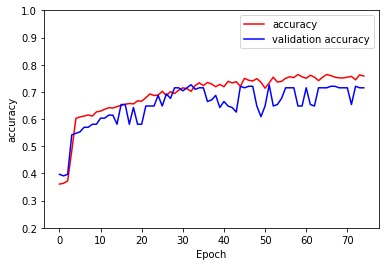

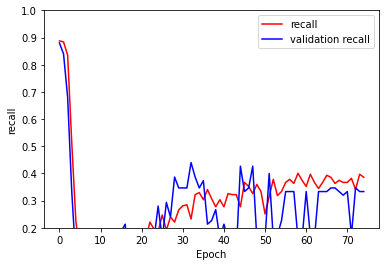

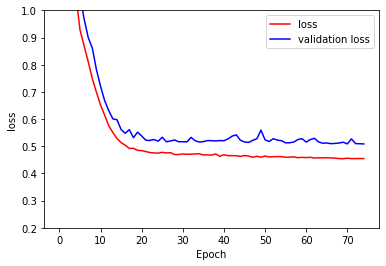

In [69]:
# Hyperparameters.
learning_rate = 0.005
epochs = 75
batch_size = 15
validation_split = 0.2
classification_threshold = 0.75

my_feature = ["Pclass","Feature_Title","Sex","Feature_Age","Ticket Number"]

my_label="Survived" 

# Discard any pre-existing version of the model.
my_model = None

# Save previous results
#prev_hist = hist
#prev_epochs = epochs

# Build and Train
my_model = build_model(learning_rate,len(my_feature),classification_threshold)
weight, bias, epochs, hist = train_model(my_model, train_df[my_feature], train_df[my_label], epochs, validation_split)

plot_results(epochs,'accuracy',hist)
plot_results(epochs,'recall',hist)
plot_results(epochs,'loss',hist)

In [70]:
weight, bias

(array([[-0.5806319 ],
        [ 0.43743482],
        [-2.058289  ],
        [ 0.00233165],
        [-0.14573899]], dtype=float32),
 array([1.5941216], dtype=float32))

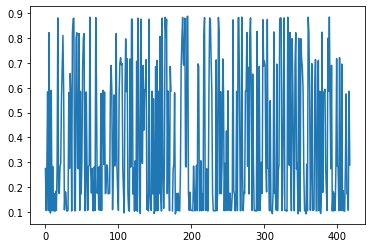

In [71]:
# Predict
plt.plot(my_model.predict(test_df[my_feature]))

In [72]:
# Prepare sumbmission file
prediction_df = test_df[["PassengerId"]].copy()

In [73]:
list_of_list = (my_model.predict(test_df[my_feature]) >= classification_threshold).astype(int).tolist()
survived_list = [item for elem in list_of_list for item in elem]
prediction_df = prediction_df.assign(Survived=survived_list)

In [74]:
prediction_df.to_csv('./deeplearning_submission.csv',index=False,header=True)

In [75]:
example_csv = pd.read_csv('./Data/gender_submission.csv')
prediction_csv = pd.read_csv('./deeplearning_submission.csv')

In [76]:
example_csv.Survived.value_counts(), prediction_csv.Survived.value_counts(), 

(0    266
 1    152
 Name: Survived, dtype: int64,
 0    355
 1     63
 Name: Survived, dtype: int64)